<a href="https://colab.research.google.com/github/rohitnikam1/Time_Series_Forecasting/blob/master/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import relevant packages

Ideally, one should set up their own virtual environment and determine the versions of each library that they are using. Here, we will assume that the colaboratory environment has some shared environment with access to common python libraries and the ability to install other required libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from IPython.display import display, HTML, display_html
import datetime
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()

# Set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/Colab_Notebooks/Time_Series_Forcasting/reviews.csv'

## Read data

In [3]:
df = pd.read_csv(path)

## Looking at data

In [4]:
# look at the data
display(df.head())

# look at the shape of the data
display(df.shape)

# look at the datatypes
display(df.dtypes)

# see if any columns have nulls
display(df.isnull().any())

# display descriptive statistics
display(df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.95, 0.99]))

,listing_id,date
0,2015,2016-04-11
1,2015,2016-04-15
2,2015,2016-04-26
3,2015,2016-05-10
4,2015,2016-05-14


(416766, 2)

listing_id     int64
date          object
dtype: object

listing_id    False
date          False
dtype: bool

,listing_id
count,4.167660e+05
mean,1.582541e+07
std,1.278406e+07
min,2.015000e+03
25%,4.027713e+06
50%,1.409896e+07
75%,2.432991e+07
85%,3.037347e+07
95%,3.994176e+07
99%,4.886878e+07


## **What are some questions that can be answered with this data?**
- Understand the limitations of your data. It is important to know what potential questions can be answered by the data. These questions can reduce, expand or modify the scope of the project.<d>
- If the scope or goal for the project is defined before digging into the data, this is a good time to revisit it.

- **Questions that can be answered**
 - Forcast future number of reviews for the Berlin area.
 - Forcast the future number of reviews for specific listings in the Berlin Area.

## **What techniques may help answer these questions?**
### **Statistical Models**
- **Ignore the time-series aspect completely and model using traditional statistical modelling toolbox** (not the best idea, since the inherent time-series order and structure is not leveraged)
 - Ex.: Regression based models
- **Univariate statistical time-series modelling**
  - Ex.: Averaging and smoothing models, ARIMA models
- **Slight modifications to univariate statistical time-series modelling**
 - Ex.: External regressors, multivariate models
- **Additive or component models**
 - Ex.: Facebook Prophet package (good for quick estimate of forecast)
- **Structural time-series modelling**
 - Ex.: Bayesian structural time-series modelling, hierarchical time-series modelling

### **Machine learning models**
- **Ignore the time-series aspect completely and model using traditional machine learning modelling toolbox**
 - Ex.: Support Vector Machines (SVMs), Random Forest Regression, Gradient-boosted Decision Trees (GBDTs)
- **Hidden Markov models (HMMs)**
- **Other sequence based models**
- **Gaussian processes**
- **Recurrent neural networks (RNNs)**

### **Additional data considerations before choosing a model**
- Whether or not to incorporat external data**
- Whether or not to keep as univariate or multivariate (i.e. which features and number of features)
- Outlier detection and removal
- Missing value imputation

## **Let's analyse some time-series data!**
### **Process the data**

In [5]:
# Rename columns
df = df.rename(columns={'date': 'ds', 'listing_id': 'ts'})
display(df.head())

# Change index to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Set index as date
df.set_index('ds', inplace=True)

# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})

# Set frequency of time-series
df_example = df_example.asfreq(freq = '1D')

# Sort the values
df_example =  df_example.sort_index(ascending = True)

# Fill NaN values with zero
df_example = df_example.fillna(value = 0)

# Show the end of the data
display(df_example.tail())

,ts,ds
0,2015,2016-04-11
1,2015,2016-04-15
2,2015,2016-04-26
3,2015,2016-05-10
4,2015,2016-05-14


,ts
ds,
2021-09-25,0.0
2021-09-26,1.0
2021-09-27,1.0
2021-09-28,1.0
2021-09-29,1.0


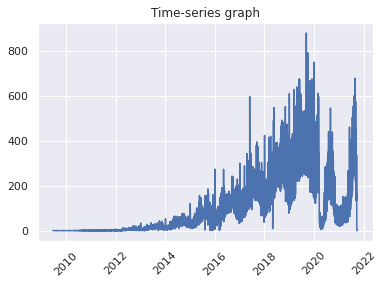

In [6]:
# Plot time-series data
f, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])

# Add title
ax.set_title('Time-series graph')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

plt.show()
plt.close()

- There does seem to be an overall increasing trend.
- Variance seems to be changing over time
- There may be some seasonality in the data.
- Not sure about outliers.

## **Look at Stationarity**
Most time-series models assume that the underlying time-series data is **stationary**. This assumption gives us some nice statistical properties that allows us to use various forecasting models.

**Stationarity** is a statistical assumption that a time-series has
 - **Constant mean**
 - **Constant variance**
 - **Autocovariance is time independent**
More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends as in the past. This general statement hold true for most training data and modelling tasks.

Sometimes we need to transform the data to make it stationary. However, this transformation then calls into question if the data is truly stationary and is suited to be modelled using these techniques.


In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
  '''
  Test stationarity using moving average statistics and Dickey-Fuller test
  Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
  '''

  # Determine rolling statistics
  rollmean = df[ts].rolling(window=12, center = False).mean()
  rollstd  = df[ts].rolling(window=12, center = False).std()

  # Plot rolling statistics
  orig = plt.plot(df[ts], color='blue', label = 'Original')
  mean = plt.plot(rollmean, color='red', label = 'Rolling mean')
  std = plt.plot(rollstd, color='black', label = 'Rolling std')
  plt.legend(loc = 'best')
  plt.title(f'Rolling Mean and Standard Deviation for {ts}')
  plt.xticks(rotation = 45)
  plt.show(block = False)
  plt.close()

  # Perform Dickey-Fuller Test
  # Null Hypothesis      (H_0): Time-series is NOT stationary.
  # Alternate Hypothesis (H_1): Time-series IS stationary.
  print('Results of Dickey-Fuller Test')
  dftest = adfuller(df[ts], autolag = 'AIC')
  dfoutput = pd.Series(dftest[:4], index = ['Test Statistic', 'p-value', '# Lags used', '# Observations used'])
  for key, value in dftest[4].items():
    dfoutput[f'Critical Value {key}'] = value
  print(dfoutput)

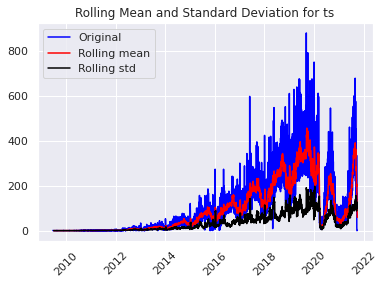

Results of Dickey-Fuller Test
Test Statistic           -2.633356
p-value                   0.086297
# Lags used              28.000000
# Observations used    4456.000000
Critical Value 1%        -3.431818
Critical Value 5%        -2.862189
Critical Value 10%       -2.567115
dtype: float64


In [10]:
test_stationarity(df = df_example, ts = 'ts')

Rolling mean and standard deviation look like they change over time. There may be some de-trending and removing seasonality involved. Based in **Dickey-Fuller Test**, because $p=0.08$, we fail to reject the null hypothesis (that the time-series data is not stationary) at the $p=0.05$ level, thus concluding that we fail to reject the null hypothesis that our **time-series data is not stationary**.

## **Corrections for Stationarity**
It is common for the time-series to have to be corrected for stationarity.
Two common reasons behind non-stationarity are:
 1. **Trend**: mean is not constant over time
 2. **Seasonality**: variance is not constant over time

 There are ways to correct for trend and seasonality, to make the time-series stationary.

 **What happens if you do not correct for these things?**
 Many things can happen, including:
  - Variance can be mis-specified
  - Model fit can be worse
  - Not leveragin valuable time-dependent nature of the data.


## **Eliminating Trend and Seasonality**
 - **Transformation**
  - Ex.: Log, Square-root, etc.
 - **Soothing**
  - Ex.: Weekly average, monthly average, rolling averages
 - **Differencing**
  - Ex.: First-order differencing
 - **Polynomial Fitting**
  - Ex.: Fit a regression model
 - **Decomposition**

 ## **Transformation, Smoothing and Differencing**
 **Looking at our data**
  - Applying log transformation, weekly moving average smoothing and differencing made the data more stationary over time. Based on **Dickey-Fuller test**, because $p \le 0.05$, we fail to reject the null hypothesis (that the time-series is not stationary) at the $p=0.05$ level, thus concluding that the **time series is stationary**.